# Homework 2-1: Phoneme Classification (Multiclass Classification)

Author: Cao Yanfei

## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task. We are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data

Download data from google drive, then upzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**Notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace.**

In [1]:
# !gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
# !unzip data.zip
# !ls

## Preparing Data

Load the training and testing data from the `.npy` file (Numpy array).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
print('Loading data...')

data_root = './dataset/timit_11/'
train_data = np.load(data_root + 'train_11.npy')
train_label_data = np.load(data_root + 'train_label_11.npy')
test_data = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train_data.shape))
print('Size of testing data: {}'.format(test_data.shape))

Loading data...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


## Utilities

In [3]:
def get_device():
    '''
    Check device.
    '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def same_seeds(seed):
    '''
    Fix random seeds.
    '''
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def plot_loss_curve(loss_record, title=''):
    '''
    Plot DNN learning curve (training and validation loss).
    '''
    total_steps = len(loss_record['train'])
    # each batch size
    x1 = np.arange(total_steps)
    # each epoch
    x2 = x1[:: len(loss_record['train']) // len(loss_record['validate'])]
    
    figure(figsize=(10, 8))
    # T10调色盘适用于离散分类，颜色名称以'tab:'为前缀
    plt.plot(x1, loss_record['train'], c='tab:red', label='training')
    plt.plot(x2, loss_record['validate'], c='tab:cyan', label='validation')
    plt.xlim(-500, 310000)
    plt.ylim(0., 5.)
    plt.xticks(np.arange(0, 310000, 50000))
    plt.yticks(np.arange(0., 6., 0.5))
    plt.xlabel('Training step/batch')
    plt.ylabel('Loss for one batch')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred_curve_on_valiset(val_loader, model, device):
    '''
    Plot DNN prediction.
    '''
    model.eval()
    
    preds, targets = [], []
    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            preds.append(pred.detach().cpu())
            targets.append(labels.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    
    figure(figsize=(8, 8))
    plt.scatter(targets, preds, c='tab:red', alpha=0.002)
    plt.plot([0, 40], [0, 40], c='tab:cyan')
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground truth v.s. prediction on validation set')
    plt.show()

## Create Dataset

In [4]:
import torch
from torch.utils.data import Dataset

D:\software\Anaconda3\installation\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        # torch.from_numpy() transfroms a numpy array into a tensor (shared memory!)
        # torch.Tensor() transfroms a numpy array into a tensor (no shared memory!)
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None
          
    def __getitem__(self, index):
        if self.label is not None:
            return self.data[index], self.label[index]
        else:
            return self.data[index]
        
    def __len__(self):
        return len(self.data)

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [6]:
VAL_RATIO = 0.2

percent = int(train_data.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train_data[: percent], train_label_data[: percent], train_data[percent:], train_label_data[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (983945, 429)
Size of validation set: (245987, 429)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [7]:
BATCH_SIZE = 64

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)     # Only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\caoya\AppData\Local\Temp/ipykernel_3852/1286471917.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.int)


Clean up the unneeded variables to save memory.

**Notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later.
The data size is quite huge, so be aware of memory usage in colab.**

In [8]:
import gc

del train_data, train_label_data, train_x, train_y, val_x, val_y
gc.collect()

0

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [9]:
import torch
import torch.nn as nn

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.layer1 = nn.Linear(429, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, 39)
        
        self.act_fn = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        
        x = self.layer2(x)
        x = self.act_fn(x)
        
        x = self.layer3(x)
        x = self.act_fn(x)
        
        x = self.out(x)
        return x

## Training

Feel free to change the training parameters here.

In [11]:
# Fix random seed for reproducibility.
same_seeds(0)

# Get device
device = get_device()
print(f'Device type: {device}')

# Training parameters
EPOCH_NUM = 20                    # number of training epoch
LEARNING_RATE = 0.0001            # learning rate

# The path where checkpoint saved
model_path = './model.ckpt'

# Create model, define a loss function and a optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Device type: cpu


In [12]:
# Start training
best_acc = 0.0
loss_record = {'train': [], 'validate': []}

for epoch in range(EPOCH_NUM):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # Training
    model.train()                                   # Set the model into training mode
    for i, data in enumerate(train_loader):        # Harness 'enumerate' to obtain the index and value of an iterable object.
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1)       # Get the index of the class with the highest probability in each row, train_pred is a tensor
        batch_loss.backward()
        optimizer.step()
        
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()        # Torch.item(): obtain the value of a tensor with only one element
        train_loss += batch_loss.item()
        
        loss_record['train'].append(batch_loss.detach().cpu().item())
    
    # Validation
    # Evaluate model accuracy and loss on validation set, if they are imrpoved, save this model
    if len(val_set) > 0:
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1)
                
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()
                
            print('Epoch: {:03d}/{:03d}, training accuracy: {:3.6f}, training loss: {:3.6f}, '\
                  'validation accuracy:  {:3.6f}, validation loss: {:3.6f}'.format(
                  epoch + 1, EPOCH_NUM, train_acc / len(train_set), train_loss / len(train_loader), 
                  val_acc / len(val_set), val_loss / len(val_loader)))
            
            # Record validation loss of average batch for each epoch
            loss_record['validate'].append(val_loss / len(val_loader))
            
            # If the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('Saved model with acc: {:.3f}'.format(best_acc / len(val_set)))
    else:
        print('Epoch: {:03d}/{:03d}, training accuracy: {:3.6f}, training loss: {:3.6f}.'.format(
              epoch + 1, EPOCH_NUM, train_acc / len(train_set), train_loss / len(train_loader)))
    

# If not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('Saved the model at the last epoch.')

Epoch: 001/020, training accuracy: 0.467302, training loss: 1.811661, validation accuracy:  0.567428, validation loss: 1.433065
Saved model with acc: 0.567
Epoch: 002/020, training accuracy: 0.594383, training loss: 1.330666, validation accuracy:  0.628639, validation loss: 1.211098
Saved model with acc: 0.629
Epoch: 003/020, training accuracy: 0.644506, training loss: 1.154064, validation accuracy:  0.660421, validation loss: 1.101216
Saved model with acc: 0.660
Epoch: 004/020, training accuracy: 0.672216, training loss: 1.052246, validation accuracy:  0.676300, validation loss: 1.038718
Saved model with acc: 0.676
Epoch: 005/020, training accuracy: 0.691347, training loss: 0.983104, validation accuracy:  0.685154, validation loss: 1.001852
Saved model with acc: 0.685
Epoch: 006/020, training accuracy: 0.705616, training loss: 0.931955, validation accuracy:  0.689301, validation loss: 0.984177
Saved model with acc: 0.689
Epoch: 007/020, training accuracy: 0.716344, training loss: 0.89

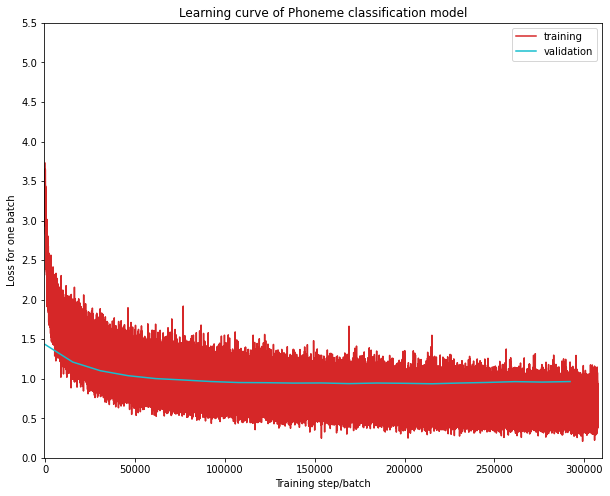

In [13]:
# Show loss variation on training set and validation set during training
plot_loss_curve(loss_record, title='Phoneme classification model')

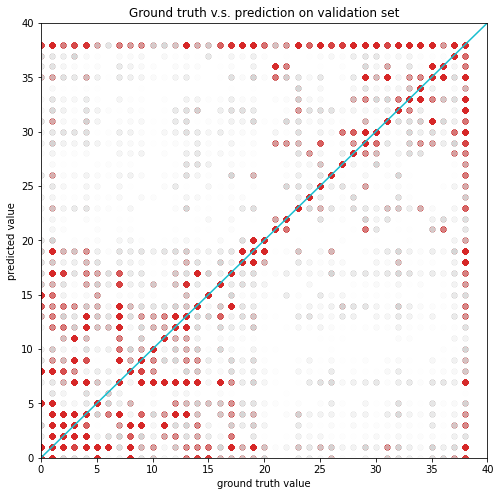

In [14]:
# Show classification prediction on validation set based on the best training model
# Create model and load weights from checkpoint
del model
model = Classifier().to(device)
best_model = torch.load(model_path)
model.load_state_dict(best_model)

plot_pred_curve_on_valiset(val_loader, model, device)

## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [15]:
# Create testing dataset
test_set = TIMITDataset(test_data, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Make prediction

In [16]:
results_predict = []
model.eval()      # Set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1)
        
        for y in test_pred.cpu().numpy():
            results_predict.append(y)

Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [17]:
with open('prediction.csv', 'w') as f:
    f.write('Index, Class\n')
    for i, y in enumerate(results_predict):
        f.write('{},{}\n'.format(i, y))

## Reference

Original source: https://github.com/ga642381/ML2021-Spring/blob/main/HW02/HW02-1.ipynb